In [2]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as td
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torch.utils.data import DataLoader
from IPython.display import HTML
from torchvision.io import read_image
import torchvision.models as models
import torch.nn.init as init
import torch.nn.functional as F


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

100%|██████████| 561753746/561753746 [00:34<00:00, 16081308.03it/s]


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


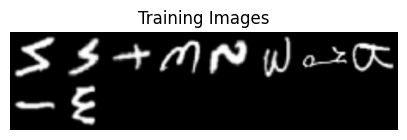

In [5]:
dataTransforms=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
															transforms.Normalize((0.5,), (0.5,))
                           ])

data_set = td.EMNIST(root="data", split='balanced', train=False, download=True, transform=dataTransforms)

data_loader = DataLoader(data_set, shuffle=True, batch_size=batch_size)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(data_loader))
plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
image, label = next(iter(data_loader))

print(image.shape)
print(label.shape)

torch.Size([128, 1, 64, 64])
torch.Size([128])


In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)
        self.sig = nn.Sigmoid()
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.sig(self.linear(out))
        return out

In [9]:
def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])

In [10]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.res = resnet56()

    def forward(self, input):
        # print("input:",input.shape)
        # Extract features using the pretrained ResNet56 model
        features = self.res(input)
        # print("Features:",features.shape)
        
        # Flatten the features
        # features = features.view(-1, 128)
        features = features.flatten()
        # print("Features View :",features.shape)
        
        # Return the output
        out = features.view(-1, 1).squeeze(1)
        # print("out : ",out.shape)
        return out


In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
# netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (res): ResNet(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (

In [14]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(10, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Starting Training Loop...
[0/10][0/147]	Loss_D: 0.0009	Loss_G: 7.2819	D(x): 0.9998	D(G(z)): 0.0007 / 0.0007
[0/10][50/147]	Loss_D: 0.0007	Loss_G: 7.4282	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006
[0/10][100/147]	Loss_D: 0.0007	Loss_G: 7.4828	D(x): 0.9999	D(G(z)): 0.0006 / 0.0006


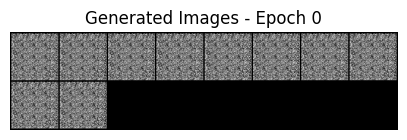

[1/10][0/147]	Loss_D: 0.0007	Loss_G: 7.5176	D(x): 0.9998	D(G(z)): 0.0005 / 0.0005
[1/10][50/147]	Loss_D: 0.0006	Loss_G: 7.7071	D(x): 0.9999	D(G(z)): 0.0005 / 0.0004
[1/10][100/147]	Loss_D: 0.0006	Loss_G: 7.7348	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[2/10][0/147]	Loss_D: 0.0005	Loss_G: 7.9221	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[2/10][50/147]	Loss_D: 0.0005	Loss_G: 7.9542	D(x): 0.9999	D(G(z)): 0.0004 / 0.0004
[2/10][100/147]	Loss_D: 0.0004	Loss_G: 8.0835	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[3/10][0/147]	Loss_D: 0.0004	Loss_G: 8.1542	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[3/10][50/147]	Loss_D: 0.0004	Loss_G: 8.1244	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[3/10][100/147]	Loss_D: 0.0004	Loss_G: 8.1277	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[4/10][0/147]	Loss_D: 0.0004	Loss_G: 8.2067	D(x): 0.9999	D(G(z)): 0.0003 / 0.0003
[4/10][50/147]	Loss_D: 0.0003	Loss_G: 8.3304	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[4/10][100/147]	Loss_D: 0.0003	Loss_G: 8.3205	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[5/1

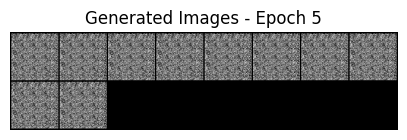

[6/10][0/147]	Loss_D: 0.0003	Loss_G: 8.4856	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[6/10][50/147]	Loss_D: 0.0003	Loss_G: 8.5421	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[6/10][100/147]	Loss_D: 0.0002	Loss_G: 8.5924	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[7/10][0/147]	Loss_D: 0.0002	Loss_G: 8.7290	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[7/10][50/147]	Loss_D: 0.0002	Loss_G: 8.7222	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[7/10][100/147]	Loss_D: 0.0002	Loss_G: 8.8306	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[8/10][0/147]	Loss_D: 0.0002	Loss_G: 8.9084	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[8/10][50/147]	Loss_D: 0.0002	Loss_G: 8.9401	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[8/10][100/147]	Loss_D: 0.0002	Loss_G: 8.9733	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[9/10][0/147]	Loss_D: 0.0001	Loss_G: 9.2134	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[9/10][50/147]	Loss_D: 0.0002	Loss_G: 9.0361	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[9/10][100/147]	Loss_D: 0.0001	Loss_G: 9.1611	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001


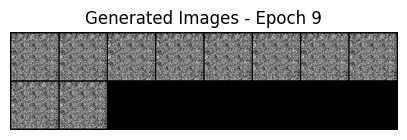

In [20]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(data_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    # Visualize generated images for fixed noise vectors at selected epochs
    if epoch == 0 or epoch == num_epochs//2 or epoch == num_epochs-1:
        fig = plt.figure(figsize=(5, 5))
        plt.axis("off")
        plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
        plt.title("Generated Images - Epoch {}".format(epoch))
        plt.show()

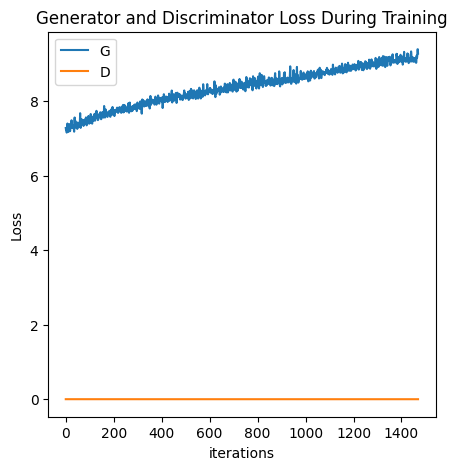

In [21]:
plt.figure(figsize=(5,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

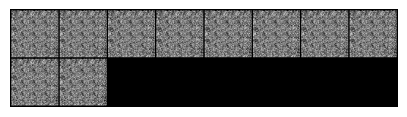

In [22]:
fig = plt.figure(figsize=(5, 5))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

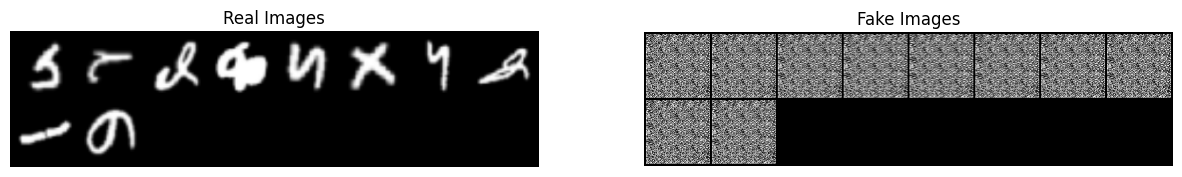

In [23]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(data_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:10], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()